# MLP

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabolary and characters and mapping
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build data set

block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)    

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
# build data set
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest =  build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
C = torch.randn((27, 2))

In [9]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [10]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [11]:
h = torch.tanh(emb.view([emb.shape[0], 6]) @ W1 + b1)

In [12]:
h

tensor([[-0.6558, -0.9614,  0.9485,  ..., -1.0000, -0.0297, -0.7911],
        [-0.6039, -0.9789, -0.9567,  ..., -1.0000,  0.8967,  0.4803],
        [-0.9996, -0.7255,  0.1346,  ..., -0.7527, -0.9404,  0.9999],
        ...,
        [ 0.9992, -0.9907,  0.2432,  ...,  1.0000, -0.6516, -0.6967],
        [ 0.9853, -0.9568,  0.9814,  ...,  1.0000, -0.9913,  0.7198],
        [ 0.9816, -0.5975, -0.4936,  ...,  0.9995,  0.2879, -0.9571]])

In [13]:
b1.shape
# 32, 100
#  1, 100

torch.Size([100])

In [14]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [15]:
logits = h @ W2 + b2

In [16]:
logits.shape

torch.Size([228146, 27])

In [17]:
counts = logits.exp()

In [18]:
prob = counts/counts.sum(1, keepdims=True)

# Summary

In [19]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [20]:
g =  torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [21]:
sum(p.nelement() for p in parameters)

11897

In [22]:
for p in parameters:
    p.requires_grad = True

In [23]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [24]:
lri = []
lossi = [] 
stepi = []

In [25]:
for i in range(200000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view([-1, 30]) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update 
    # lr = lrs[i]
    lr = 0.1 if  i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track lr
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())


1.8941993713378906


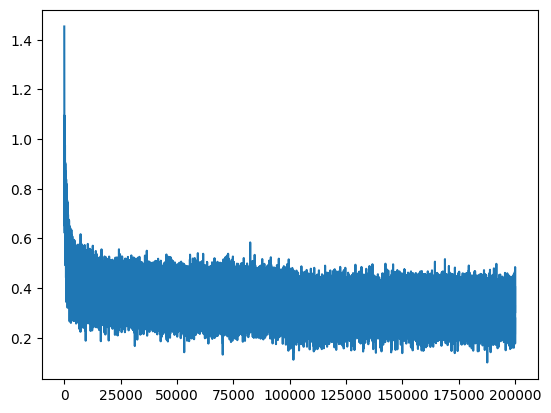

In [26]:
plt.plot(stepi, lossi)

In [36]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view([-1, 30]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1191, grad_fn=<NllLossBackward0>)

In [37]:
# validation loss
emb = C[Xdev]
h = torch.tanh(emb.view([-1, 30]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1647, grad_fn=<NllLossBackward0>)

In [38]:
# test loss
emb = C[Xtest]
h = torch.tanh(emb.view([-1, 30]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytest)
loss

tensor(2.1609, grad_fn=<NllLossBackward0>)

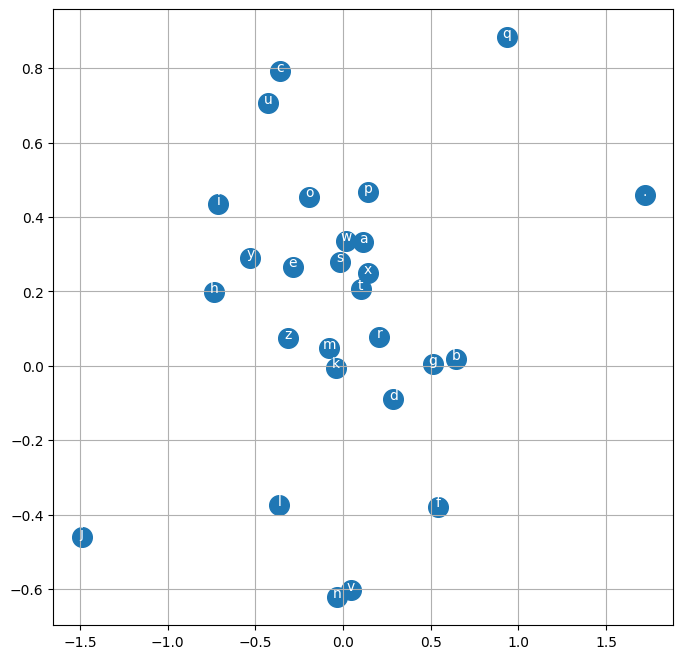

In [34]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i],ha='center', color='white')
plt.grid('minor')

In [30]:
# training split, validation split, test split
# 80%, 10%, 10%

In [39]:
g =  torch.Generator().manual_seed(2147483647+10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view([1, -1]) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


carpavra.
jehlan.
kemori.
taty.
skanden.
jazhutlan.
elyn.
jareei.
ner.
keah.
maiir.
kaleigh.
ham.
jord.
quint.
suli.
war.
adbi.
wanthonderryni.
jace.
